# **Maestría en Inteligencia Artificial Aplicada**
## **Curso: Proyecto Integrador**
### Tecnológico de Monterrey
### Equipo 9
### Jorge Luis Arroyo Chavelas (A01793023)
### **Avance 1. Análisis exploratorio de datos**

# EDA - IRPO: Resumes data
In this analysis, we will be examining data provided by the OperAI team, specifically focusing on information derived from resumes. This dataset originates from a comprehensive data mining process and has been compiled into several CSV files. Subsequently, these files have been stored in a Postgres database using the script detailed below.

**Loading stagging data script**
``` python
    # Libraries
    import os
    import pandas as pd
    from sqlalchemy import create_engine
    from dotenv import load_dotenv
    load_dotenv()

    # Connection variables
    DATABASE_URL = os.getenv("DATABASE_URL")
    engine = create_engine(DATABASE_URL)
    directory_path = "../db/data/cv/"

    # Main function
    def main():
        # Dataframe to hold all values
        df = pd.DataFrame()
        
        # Iterate through all files and concat those into the main dataframe
        for file in os.listdir(directory_path):
            df = pd.concat([df, pd.read_csv(f"{directory_path}{file}")])

        # Save the main dataframe into staging table in pgdb
        df.to_sql('cv_data', con=engine, if_exists='replace', index=False, schema="staging")
        print(f'Table cv_data has been successfully uploaded to the database. {df.shape}')


    if __name__ == '__main__':
        main()
```

After the initial data storage in the database's staging area, it underwent a cleaning process via an ETL (Extract, Transform, Load) script to prepare the dataset for our analysis. 

**ETL SQL Script**
``` sql
-- Define ML_RESOURCE Table
DROP TABLE IF EXISTS ML_RESOURCE;
CREATE TABLE IF NOT EXISTS ML_RESOURCE (
	  RESOURCE_KEY text
	, RESOURCE_TITLE text
	, RESOURCE_TEXT text
	, RESOURCE_SUMMARY text 
	, RESOURCE_SKILLS text
	, RESOURCE_EXPERIENCE text
	, RESOURCE_EDUCATION text
);

-- Some instances might have dups, we will take the one who has more significant data (or random)
DROP TABLE IF EXISTS TEMP_STEP0;
CREATE TEMPORARY TABLE IF NOT EXISTS TEMP_STEP0 AS
SELECT	ROW_NUMBER() OVER (
			PARTITION BY L.FULL_ID 
			ORDER BY L.DATA_COMPLETNESS DESC, L.NUMERIC_ID ASC
		) AS RNK
		, *
FROM	staging.cv_data AS T
LEFT JOIN LATERAL ( SELECT
		  CASE WHEN T."Experience" IS NOT NULL THEN 1 ELSE 0 END
		+ CASE WHEN T."Skills" IS NOT NULL THEN 1 ELSE 0 END
		+ CASE WHEN T."Education" IS NOT NULL THEN 1 ELSE 0	END
		, REVERSE(SUBSTRING(REVERSE("Link"), 0, STRPOS(REVERSE("Link"), '/')))
		, REVERSE(SUBSTRING(REVERSE("Link"), 0, STRPOS(REVERSE("Link"), '-')))
		) AS L(DATA_COMPLETNESS, FULL_ID, NUMERIC_ID)
		ON TRUE;

-- Save the initial ML dataset for resources 
INSERT INTO ML_RESOURCE
SELECT	DISTINCT
		NUMERIC_ID::TEXT AS RESOURCE_KEY
		, TRIM(REPLACE(REPLACE(FULL_ID, NUMERIC_ID, ''), '-', ' '))::TEXT AS RESOURCE_TITLE
		, "Content"::TEXT AS RESOURCE_TEXT
		, "Summary"::TEXT AS RESOURCE_SUMMARY
		, "Skills"::TEXT AS RESOURCE_SKILLS
		, "Experience"::TEXT AS RESOURCE_EXPERIENCE
		, "Education"::TEXT AS RESOURCE_EDUCATION
FROM	TEMP_STEP0
WHERE	RNK = 1;
```

he execution of the ETL script results in the creation of a "ML_RESOURCE" table within the public schema of our database cluster. This table serves as the foundation for our analysis. To ensure the verification and replication of our exploratory data analysis (EDA), a portion of the database is also provided.

The analysis can be adapted based on the environment and the availability of the original data. This flexibility is managed through the use of a global variable REPLICATION_FLAG=[True/False]. Setting this variable to True indicates that the dataset will be replicated using an external CSV file, whereas setting it to False signifies direct data retrieval from the aforementioned database.

In [126]:
## Choose False if you have access to the DB or True if you are using a csv replication file.
REPLICATION_FLAG = False

In [127]:
## env variables
import os
from dotenv import load_dotenv

## Call and manage data
import pandas as pd
import numpy as np
from sqlalchemy import create_engine, text
from collections import Counter


## Natural Language
import gensim
from gensim import corpora
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import nltk
nltk.download('punkt')
nltk.download('stopwords')

# Visualization
from wordcloud import WordCloud
from matplotlib import pyplot as plt
import seaborn as sns
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis


## Init
nltk.download('stopwords')
nltk.download('punkt')
load_dotenv()
%matplotlib inline  


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/dataalchemist/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dataalchemist/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dataalchemist/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/dataalchemist/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Call data

In [128]:
## Call data - either from DB or from csv file
if REPLICATION_FLAG:
    df = pd.read_csv('extract.csv')
else: 
    DATABASE_URL = os.getenv("DATABASE_URL", "")
    engine = create_engine(DATABASE_URL)
    df = pd.read_sql(text("SELECT * FROM public.ML_RESOURCE;"), engine.connect())
    df.sample(n=100, random_state=42).to_csv('./extract.csv', index=False)

# Visualize data
print(f"dataframe of shape: {df.shape}")
display(df.head(2))
null_counts = df.isnull().sum()
print("---- nulls -----")
print(null_counts)


dataframe of shape: (3566, 7)


,resource_key,resource_title,resource_text,resource_summary,resource_skills,resource_experience,resource_education
0,001599f915214ef19135cfa5398e06b8,data scientist,"Jessica Claire\nMontgomery Street, San Francis...",Highly driven Data scientist with 5 years of e...,"Machine learning,Statistical Analysis,Data Min...",Work History\n06/2019 to 12/2020\nData Scienti...,Education\n01/2021\nMaster of Science: Compute...
1,002a348664824e8ea8bc953b9c727365,python developer intern,"Jessica Claire\nMontgomery Street, San Francis...",Worked on ecommerce website and finished it in...,Python; Java; Spring; Hibernate; SQL; JavaScri...,"Work Experience\nPython Developer Intern, 07/2...",Education and Training\nMaster of Science: Com...


---- nulls -----
resource_key             0
resource_title           0
resource_text            0
resource_summary        17
resource_skills        587
resource_experience      0
resource_education      17
dtype: int64


The database contains detailed information extracted from resumes. Each entry includes a title and the full content of the resume. Additionally, there are specific columns for summary, skills, experience, and education, which have been derived through data mining techniques from the resume content. These fields are particularly valuable for our purposes, as they enable us to develop a model that can identify these sections in free-format resumes. Identifying these areas is crucial for the later stages of the project, where we will match candidates to tasks or job opportunities. However, our current focus is on understanding the data we have.

To begin, let's explore the types of profiles present in our dataset by examining the most common titles that the candidates use to describe themselves.

<Axes: title={'center': 'Top 10 job titles'}, ylabel='resource_title'>

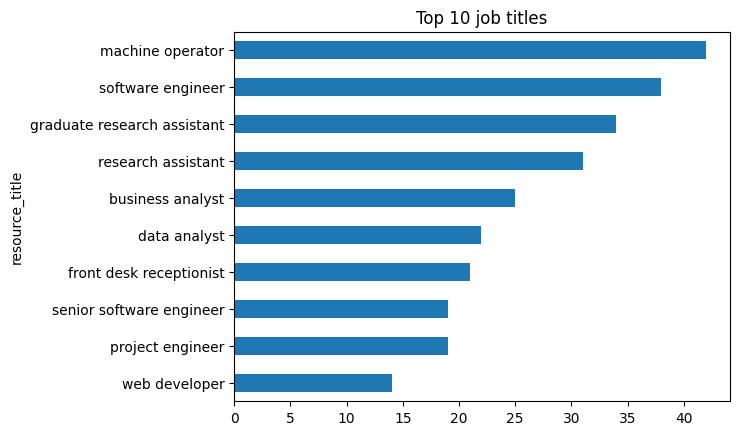

In [129]:
chart_jobtitles = (
    df
    .resource_title
    .value_counts()
    .sort_values(ascending=False)[0:10]
    .sort_values(ascending=True)
    .plot(kind='barh', title="Top 10 job titles")
)
display(chart_jobtitles)

Depending on whether you're working with the full dataset or a sample, your observations from the chart may vary. However, it's common to notice a significant presence of profiles related to analytics, development, and other specialized fields. This distribution is not random but reflects the targeted nature of the data mining process that was initially employed to compile the dataset.

To gain a clearer understanding of the content within our dataset, we'll now delve into an exploration of the words found in each section: the complete text of the resume (full curriculum), as well as the skills, experience, and education sections. This analysis will help us discern the specific language and terminologies prevalent in each area, providing insights into the professional backgrounds and expertise of the individuals in our dataset.

In [130]:
def plot_word_cloud_barh(df, column):
    # Combine all text in the column
    text = ' '.join(df[column].dropna().values)
    
    # Tokenize and remove stop words
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    words = [word for word in words if word.isalpha() and word.lower() not in stop_words]
    
    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(' '.join(words))
    
    # Generate top 10 words for Barh chart
    word_counts = Counter(words)
    top_words = word_counts.most_common(10)
    words_df = pd.DataFrame(top_words, columns=['Word', 'Frequency'])
    
    # Plotting
    fig, axs = plt.subplots(1, 2, figsize=(20, 10))
    
    # Word Cloud
    axs[0].imshow(wordcloud, interpolation='bilinear')
    axs[0].axis('off')
    axs[0].set_title(f'Word Cloud for {column}', fontsize=20)
    
    # Barh Chart
    sns.barplot(x='Frequency', y='Word', data=words_df, ax=axs[1], palette='viridis')
    axs[1].set_title(f'Top 10 Words in {column}', fontsize=20)
    
    plt.show()

In [131]:
plot_word_cloud_barh(df, 'resource_text')

When analyzing the content of the resumes, it becomes apparent that the information is quite varied. While there are mentions of specific programming languages and skills, which are expected in such a dataset, we also encounter general terms like "City" and "State," as well as placeholder names such as "Jessica Claire." This diversity in the dataset is anticipated, given the wide range of topics and the sparseness of the data. Such variety indicates that the resumes encompass a broad spectrum of professions and personal details, making it challenging to discern clear patterns or focus areas without further refinement and analysis.

/var/folders/3g/bsyh5znn5tlf6y65fb7bt04h0000gn/T/ipykernel_1247/3180178105.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Word', data=words_df, ax=axs[1], palette='viridis')


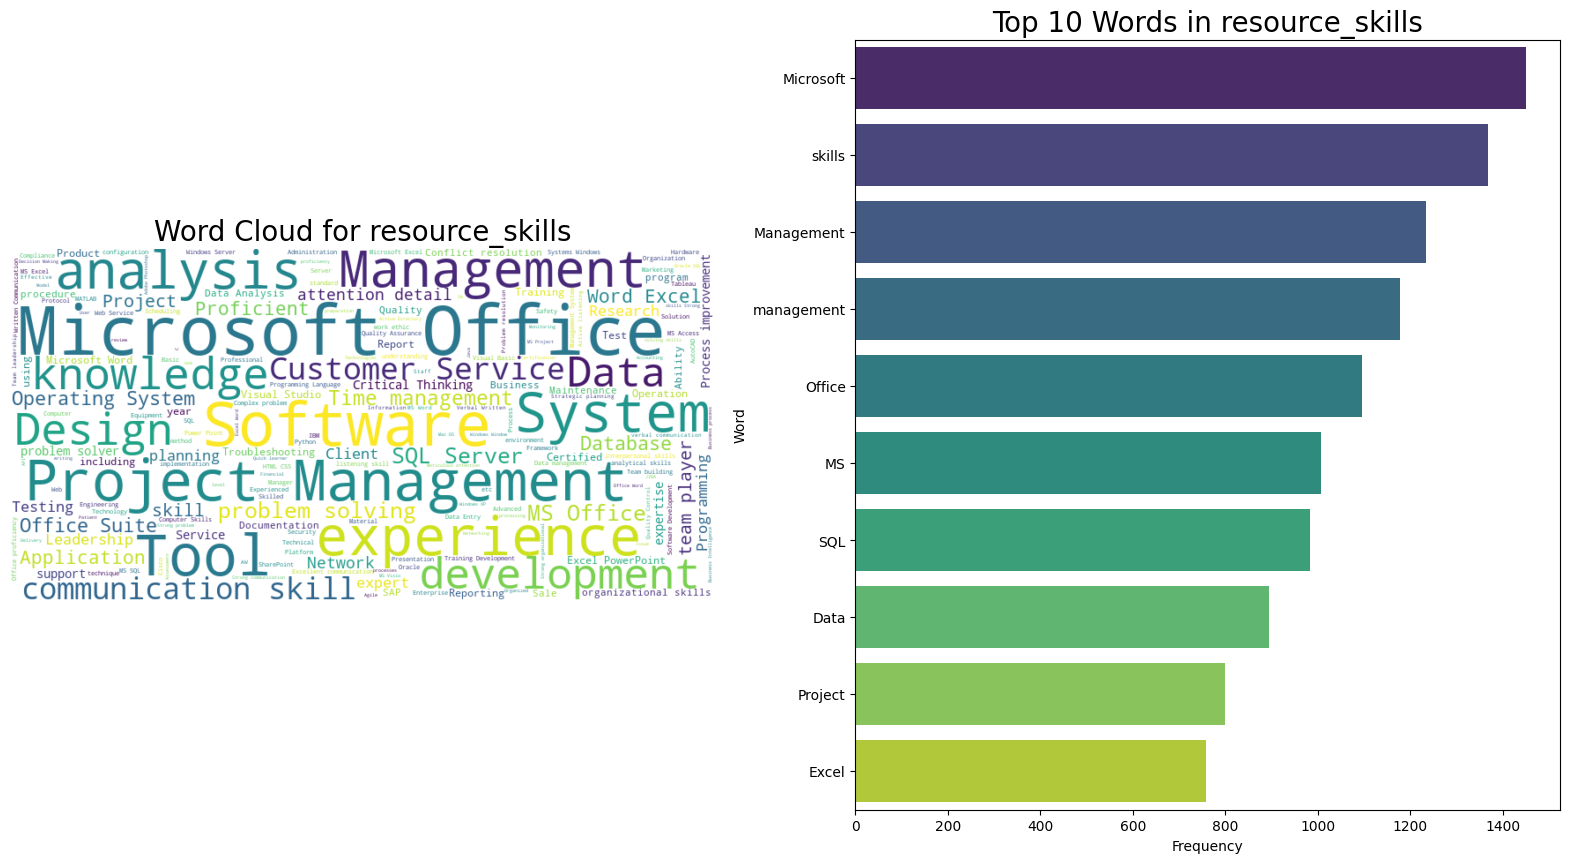

In [ ]:
plot_word_cloud_barh(df, 'resource_skills')


Upon examining the 'Skills' section of the resumes, we observe a mix of software proficiency alongside various hard and soft skills. This diversity reflects the range of competencies that candidates choose to highlight, from technical abilities to interpersonal qualities.

/var/folders/3g/bsyh5znn5tlf6y65fb7bt04h0000gn/T/ipykernel_1247/3180178105.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Word', data=words_df, ax=axs[1], palette='viridis')


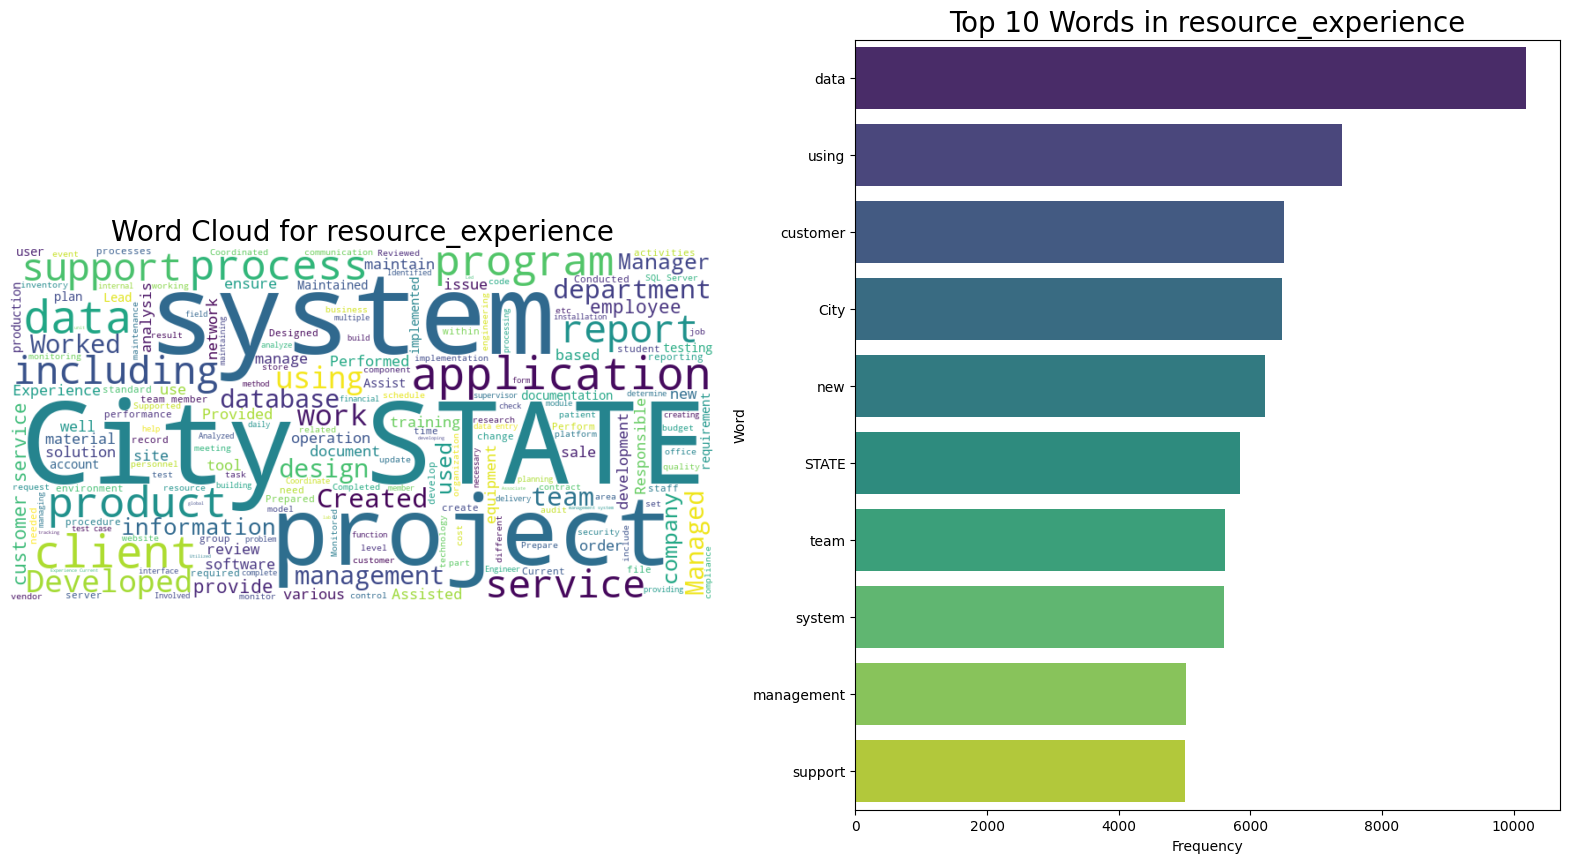

In [ ]:
plot_word_cloud_barh(df, 'resource_experience')


The 'Experience' section bears a resemblance to the overall content of the resumes, which is logical considering it often constitutes a significant portion of a resume. While there's a reduction in irrelevant data such as personal names, generic terms like "State" and "City" still surface, likely as part of the location details associated with previous employment.

/var/folders/3g/bsyh5znn5tlf6y65fb7bt04h0000gn/T/ipykernel_1247/3180178105.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Word', data=words_df, ax=axs[1], palette='viridis')


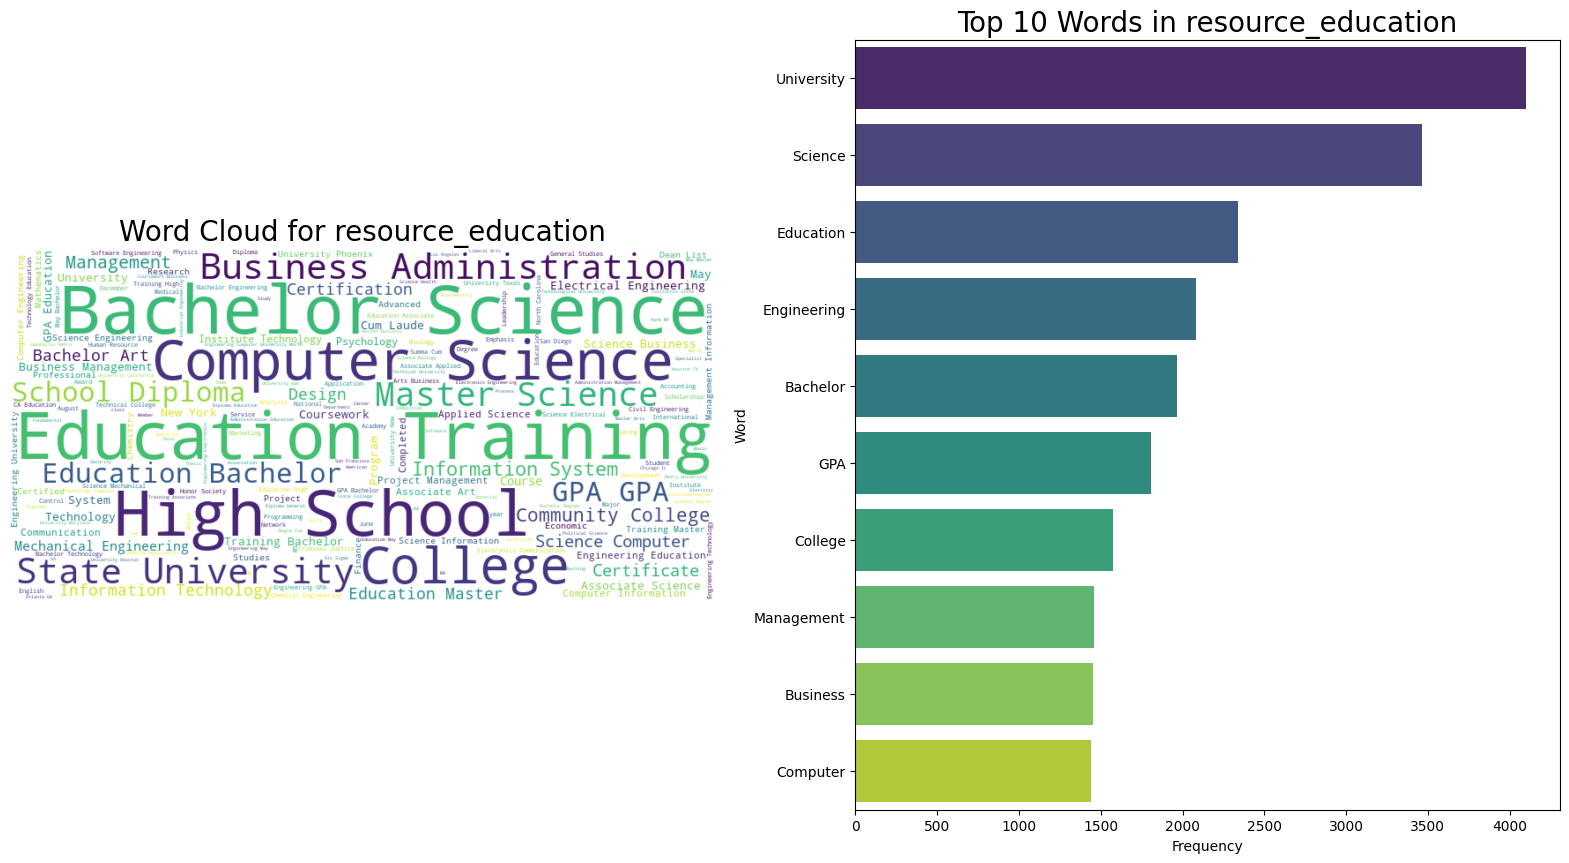

In [ ]:
plot_word_cloud_barh(df, 'resource_education')

In the 'Education' segment, we find references to academic qualifications and titles, but there's a notable absence of detailed specialization. This pattern is understandable, as broader terms like "Bachelor's" are more common than specific degrees, leading to a higher frequency of generic educational titles. This trend underscores the challenge in extracting distinct areas of study or expertise from the education section without more granular data.

Next, we will delve into visualizing the distribution of tokens across each of the mentioned columns—namely, the full text of the resumes, skills, experience, and education sections. This analysis will help us gauge the range and frequency of words used in each area, providing insights into the depth and variety of content within the resumes.

Additionally, we will examine the lexical diversity within each column to understand the extent of variation in language and terminology. Lexical diversity measures the richness of a text's vocabulary, indicating how varied the language is within a given section. By assessing this, we can better comprehend the complexity and uniqueness of the information presented in each part of the resumes, shedding light on the specificity and breadth of skills, experiences, and educational backgrounds that candidates bring to the table.

In [ ]:
def analyze_text_column(df, column):
    def calculate_vocabulary_sizes(text_series):
        word_counts_per_row = []
        all_words = []

        for text in text_series.dropna():
            words = word_tokenize(text)
            words = [word.lower() for word in words if word.isalpha()]
            word_counts_per_row.append(len(words))
            all_words.extend(words)

        return word_counts_per_row, all_words

    def calculate_lexical_diversity(all_words):
        unique_words = set(all_words)
        total_words = len(all_words)
        if total_words > 0:
            return len(unique_words) / total_words
        else:
            return 0

    def plot_histogram(word_counts_per_row):
        # Plotting Histogram
        plt.figure(figsize=(10, 6))
        plt.hist(word_counts_per_row, bins=20, color='skyblue')
        plt.title(f'Histogram of Word Counts for {column}')
        plt.xlabel('Word Count per Row')
        plt.ylabel('Frequency')
        plt.show()

    def print_statistics(word_counts_per_row, lexical_diversity):
        # Calculating Statistics
        mean = np.mean(word_counts_per_row)
        median = np.median(word_counts_per_row)
        min_size = np.min(word_counts_per_row)
        max_size = np.max(word_counts_per_row)
        stddev = np.std(word_counts_per_row)

        print(f'Statistics for {column}:')
        print(f'Mean: {mean}')
        print(f'Median: {median}')
        print(f'Min: {min_size}')
        print(f'Max: {max_size}')
        print(f'STDDEV: {stddev}')
        print(f'Lexical Diversity: {lexical_diversity}')

    # Main analysis process
    word_counts_per_row, all_words = calculate_vocabulary_sizes(df[column])
    lexical_diversity = calculate_lexical_diversity(all_words)
    plot_histogram(word_counts_per_row)
    print_statistics(word_counts_per_row, lexical_diversity)


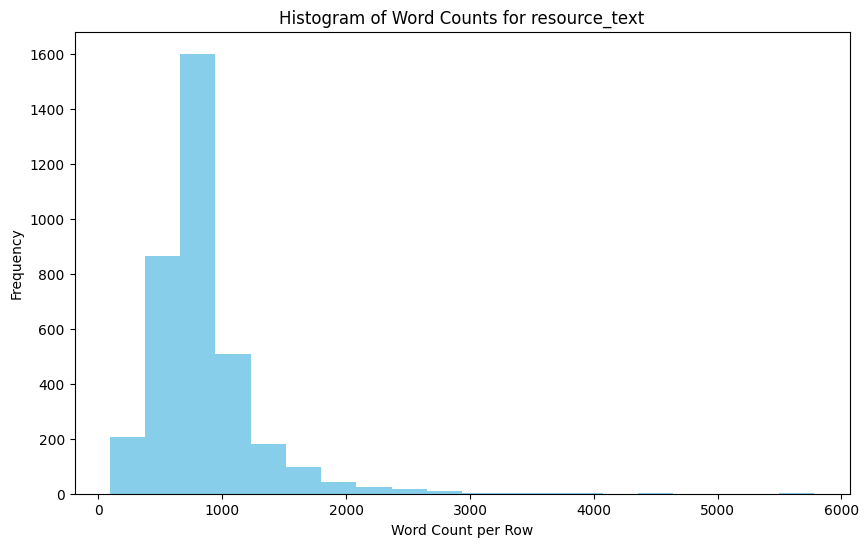

Statistics for resource_text:
Mean: 840.4397083567022
Median: 749.0
Min: 91
Max: 5781
STDDEV: 398.3619617060535
Lexical Diversity: 0.018990606631680663


In [ ]:
analyze_text_column(df, 'resource_text')


The full text of the resumes, encompassing all the data, unsurprisingly contains the greatest number of distinct tokens among all the sections. This diversity reflects the comprehensive nature of resumes, which include various elements such as personal information, professional experience, educational background, skills, and more.

Despite this wide range of tokens, the lexical diversity within the full text is relatively low. This phenomenon can be attributed to the origin of the data; since all the resumes were sourced from a consistent data mining process, there's a natural tendency for the language and terminology to converge. Common phrases, industry-specific jargon, and standard resume formats contribute to a uniformity in word usage, limiting the variation in vocabulary across the dataset. This consistency is indicative of the shared context and purpose underlying the resumes, despite the broad scope of content they encompass.





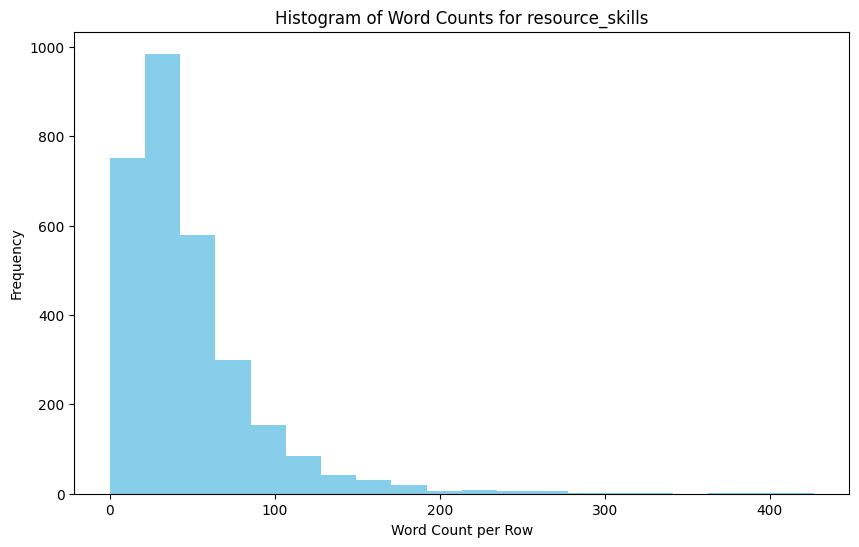

Statistics for resource_skills:
Mean: 47.566633098355155
Median: 36.0
Min: 0
Max: 427
STDDEV: 40.61236334135023
Lexical Diversity: 0.08513701385311324


In [ ]:
analyze_text_column(df, 'resource_skills')

The 'Skills' section, being a subset of the full resume text, naturally contains fewer distinct tokens. However, it exhibits a higher lexical diversity compared to the full text. This increased diversity suggests that the terms used within the 'Skills' section are more varied and less repetitive, likely due to the need to specify a wide range of technical abilities, software proficiencies, and soft skills.

The higher lexical diversity within the 'Skills' section indicates that certain skill-related terms, which may appear in the broader context of the full resume, are emphasized and repeated less frequently within this focused subset. This observation implies a potential overlap of terminology between the 'Skills' section and other parts of the resume, yet with a distinct concentration of unique terms within the 'Skills' area. This pattern underscores the specialized nature of the 'Skills' section, where candidates are likely to list diverse competencies to showcase their qualifications effectively.

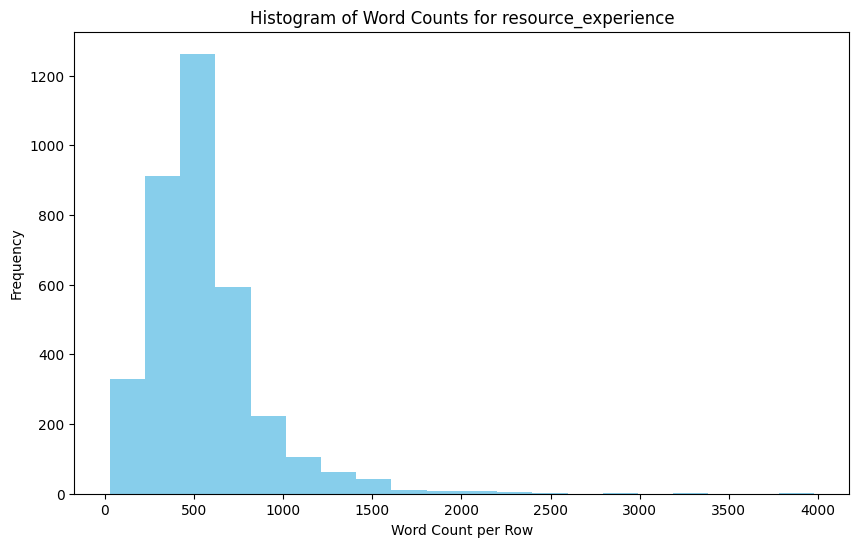

Statistics for resource_experience:
Mean: 550.2366797532248
Median: 503.0
Min: 26
Max: 3979
STDDEV: 312.9455613247407
Lexical Diversity: 0.021842433582856303


In [ ]:
analyze_text_column(df, 'resource_experience')

The 'Experience' section closely mirrors the full resume content, which aligns with the expectation that professional experience often occupies a substantial portion of a resume. This similarity suggests that the narrative and terminology used to describe previous roles and accomplishments significantly contribute to the overall content of the resume, reinforcing the notion that the 'Experience' section is a pivotal component of a candidate's profile.

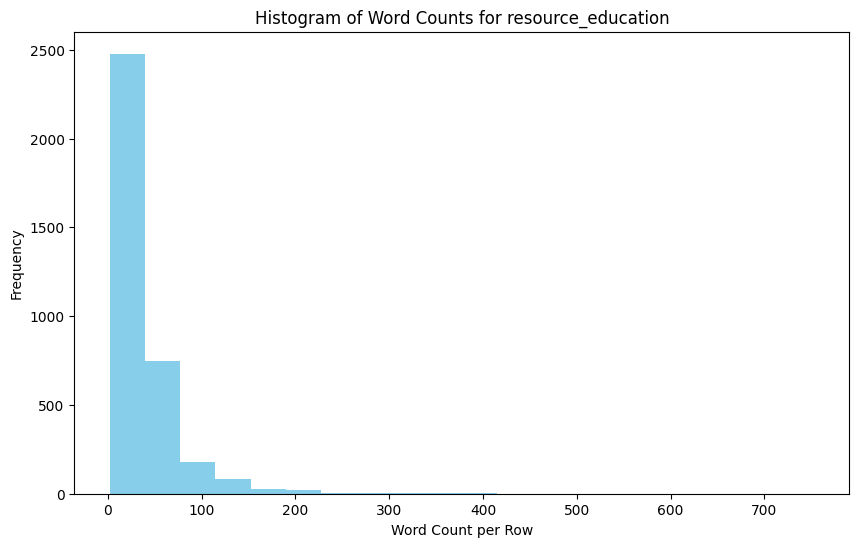

Statistics for resource_education:
Mean: 38.12764158918005
Median: 27.0
Min: 2
Max: 753
STDDEV: 38.517575216416425
Lexical Diversity: 0.08198647600044341


In [ ]:
analyze_text_column(df, 'resource_education')

'Education' section, despite its brevity, it exhibits a high level of lexical diversity. This diversity can be attributed to the inclusion of both common educational qualifications (like "Bachelor" or "Engineering") and more variable elements such as specific fields of study, institutions, and locations. These unique details contribute to the richness of vocabulary within the 'Education' section. The presence of terms like "Engineering" across multiple sections, such as 'Education', 'Experience', and 'Skills', exemplifies the overlap in content. For instance, a candidate might list "Bachelor in Engineering" under 'Education', detail engineering-related job roles under 'Experience', and mention specific competencies like "Data Engineering" under 'Skills'. This interconnectedness across sections explains the observed lexical diversity and highlights the integrated nature of the information presented in resumes.

Moving forward, we will focus on the top 10 job titles from our dataset and apply Latent Dirichlet Allocation (LDA) clustering to discern patterns within these resumes. This analysis aims to identify whether certain job titles group together due to similarities in their resumes, as well as to spot any distinct differences between them. By doing so, we can uncover if resumes within similar job categories share common terms and themes, whereas those from different fields diverge in their content.

We'll start by listing the top 10 job titles, which will serve as our basis for LDA clustering. Following that, we'll utilize the pyLDAvis tool to visually explore the results of our LDA model. This interactive visualization will enable us to see how the job titles cluster together and the extent to which their associated resumes share or differ in terms of key words and topics.

This analysis is crucial for validating our approach to profiling and segmenting the dataset. By confirming that similar profiles cluster together while distinct ones diverge, we establish a strong foundation for developing a classification system or a matching score algorithm. Such a system could effectively match candidates to jobs by aligning their resumes with job requirements, based on the underlying themes and skills extracted through LDA clustering.

In [ ]:
def preprocess_text(text):
    tokenizer = RegexpTokenizer(r'\w+')
    stop_words = set(stopwords.words('english'))
    tokens = tokenizer.tokenize(text.lower())
    filtered_tokens = [token for token in tokens if token not in stop_words and len(token) > 1]
    return filtered_tokens

top_10_titles = df['resource_title'].value_counts().nlargest(10).index
print(top_10_titles)

filtered_df = df[df['resource_title'].isin(top_10_titles)]

texts = [preprocess_text(text) for text in filtered_df['resource_text'].dropna()]

dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

lda_model = models.LdaModel(corpus, num_topics=10, id2word=dictionary, passes=15, random_state=42)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis)

Index(['machine operator', 'software engineer', 'graduate research assistant',
       'research assistant', 'business analyst', 'data analyst',
       'front desk receptionist', 'project engineer',
       'senior software engineer', 'web developer'],
      dtype='object', name='resource_title')


The observation of job titles such as "Software Engineer" and "Senior Software Engineer" clustering closely together in the LDA analysis is expected, given the inherent similarities between these roles. This proximity suggests that the resumes for these positions share a significant amount of terminology and topics, reflecting the common skills and experiences required in the software engineering field.

Moreover, the presence of clusters with a high degree of overlap indicates that there are groups of job titles whose associated resumes share a substantial portion of their content. This overlap can be attributed to similar job functions, required skills, and industry terminology, underscoring the relatedness of these roles.

On the other hand, the identification of distinct clusters, where the keywords and topics significantly differ from those in the software engineering clusters and from each other, suggests that the LDA model is effectively segregating the resumes based on their thematic content. This differentiation is key for identifying unique professional domains within the dataset, indicating that the resumes can indeed be categorized by topics derived from their token content.

These findings validate the utility of topic modeling in analyzing resume data, demonstrating its potential in distinguishing between closely related job roles as well as in separating distinct professional fields. This capability is instrumental for creating sophisticated classification or matching systems that can accurately align candidate profiles with appropriate job opportunities based on the substantive content of their resumes.

The insights derived from the LDA topic modeling offer intriguing avenues for further analysis, particularly in understanding the nuances within job descriptions. The emergence of distinct groups based on textual content underscores the potential for categorization, suggesting that developing algorithms to assess similarities between job roles and their descriptions is a viable path forward. This is particularly compelling as it hints at the underlying structure within the corpus, where specific segments of text are characterized by unique terminologies.

The observation of textual overlaps within the dataset is noteworthy, as it points to the presence of common themes or requirements across different job roles. This finding lays the groundwork for more sophisticated modeling techniques that could focus on dissecting the text into its constituent sections. The prospect of predicting the categorization of text lines—whether they pertain to skills, experience, or other criteria—opens up a novel approach to parsing job descriptions. This method aligns well with the structured nature of many job postings, where distinct sections are dedicated to outlining required qualifications, skills, and experiences.

Such an analytical framework not only enhances the precision of matching candidates with job roles but also contributes to a more nuanced understanding of the job market's dynamics. By identifying and categorizing the key components of job descriptions, future models can be tailored to recognize and prioritize the most relevant aspects of a candidate's qualifications, thereby streamlining the recruitment process. This approach not only holds promise for improving the efficiency of job matching but also offers a deeper insight into the evolving trends and requirements within various industries.

To finalize here are the guide questions and answers:


##### **Are there missing values in the dataset? Can patterns of absence be identified?**

Yes, some of the resumes don't have clear out some parts like skills.


##### **What are the summary statistics of the dataset?**

Showed in the histograms. We have 3,566 unique resumes; the resumes have a median tkoen value of 750 words.

##### **Are there outliers in the dataset?**

Data is free text.

##### **What is the cardinality of the categorical variables?**

Data is free text.


##### **Are there skewed distributions in the dataset? Do we need to apply any nonlinear transformations?**

Data is free text.

##### **Are temporal trends identified? (In case the set includes a time dimension).**

Data is free text.


##### **Is there a correlation between dependent and independent variables?**

Data is free text.

##### **How are the data distributed based on different categories?**

Data is free text.


##### **Are there patterns or clusters in the data with similar characteristics?**

Yes, as showed in the LDA simmilar profiles might have a simmilar selection of words.


##### **Should images be normalized for better visualization?**

Data is free text.

##### **Is there an imbalance in the classes of the target variable?**

This is not a classification problem (yet..)